# Proving Neyman Orthogonality 

We start with the standard linear model formulation:

$$
Y = \alpha D + \beta' W + \epsilon
$$

Where:
- $\alpha$ is the coefficient of interest linked to the treatment variable $D$.
- $\beta$ is a vector of coefficients associated with the control variables $W$.
- $\epsilon$ is the error term.

The residuals from Lasso regressions:
- For the outcome $Y$ on controls $W$, let the estimate be $\gamma_{YW}'$.
- For the treatment $D$ on controls $W$, let the estimate be $\gamma_{DW}'$.

The residuals are defined as:
$$
\tilde{Y} = Y - \gamma_{YW}'W
$$
$$
\tilde{D} = D - \gamma_{DW}'W
$$

We define the true parameter vector:
$$
\eta^0 = (\gamma_{DW}', \gamma_{YW}')'
$$

Since $\alpha$ is a function of $\eta$, where $\eta = (\eta_1', \eta_2')'$, we aim to show that $\alpha$ is insensitive to local perturbations around $\eta^0$:
$$
D = \frac{\partial \alpha(\eta^0)}{\partial \eta} = 0
$$

### Proposed Model

We assume the model:
$$
\tilde{Y} = a \tilde{D} + \mu
$$
Where $\alpha = \arg\min_{a \in \mathbb{R}} E[(\tilde{Y} - a \tilde{D})^2]$. $\alpha$ is the true value as it minimizes the expected square residuals.

The moment condition for the model is:
$$
M(a, \eta) = E[(\tilde{Y}(\eta_1) - a \tilde{D}(\eta_2)) \tilde{D}(\eta_2)]
$$
Where:
$$
\tilde{Y}(\eta_1) = Y - \eta_1'W
$$
$$
\tilde{D}(\eta_2) = D - \eta_2'W
$$

At true values $\eta = \eta^0$:
$$
\tilde{Y} = Y - \gamma_{YW}'W
$$
$$
\tilde{D} = D - \gamma_{DW}'W
$$

### Application of the Implicit Function Theorem

To derive $a$ with respect to $\eta$:
$$
\frac{\partial a}{\partial \eta} = -\partial_a M(\alpha, \eta^0)^{-1} \partial_\eta M(\alpha, \eta^0)
$$
To demonstrate $\frac{\partial \alpha(\eta^0)}{\partial \eta} = 0$, we need $\partial_\eta M(\alpha, \eta^0)$ to be zero since $\partial_a M(\alpha, \eta^0)$ cannot be zero.

### Derivatives Calculation

For the first component:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_1} = E\left[\frac{\partial \tilde{Y}(\eta_1)}{\partial \eta_1} \tilde{D}\right]
$$
Given that $\tilde{Y} = Y - \eta_1'W$:
$$
\frac{\partial \tilde{Y}}{\partial \eta_1} = -W
$$
Thus:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_1} = E[-W \tilde{D}] = 0
$$

For the second component:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_2} = E\left[(-a \frac{\partial \tilde{D}(\eta_2)}{\partial \eta_2})\tilde{D} + \frac{\partial \tilde{D}(\eta_2)}{\partial \eta_2}(\tilde{Y} - a\tilde{D})\right]
$$
Since $\tilde{D} = D - \eta_2'W$:
$$
\frac{\partial \tilde{D}}{\partial \eta_2} = -W
$$
Resulting in:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_2} = -E[W\tilde{Y}] + 2E(\alpha W\tilde{D}) = 0
$$

This confirms that $\frac{\partial M}{\partial \eta_1} = 0$ and $\frac{\partial M}{\partial \eta_2} = 0$. Therefore, $\frac{\partial \alpha(\eta^0)}{\partial \eta} = 0$ is proven.


# Simulation Design

In [1]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [2]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy as hdm

In [3]:
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Simulation Design 1

In [4]:
# Set seed
np.random.seed(0)
B1 = 100
Naive = np.zeros( B1 )
Orthogonal = np.zeros( B1 )

In [7]:
for i in range( 0, B1 ):
    n = 1000
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selection method
    r_lasso_estimation = hdm.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

    SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
    if sum(SX_IDs) == 0 : 
        Naive[ i ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

    # In both cases we save D coefficient
        
    # Regress residuals. 
    resY = hdm.rlasso( X , Y , post = False ).est[ 'residuals' ]
    resD = hdm.rlasso( X , D , post = False ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

In [8]:
Orto_breaks = [-1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
Naive_breaks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]

Text(0.5, 0, 'Naive')

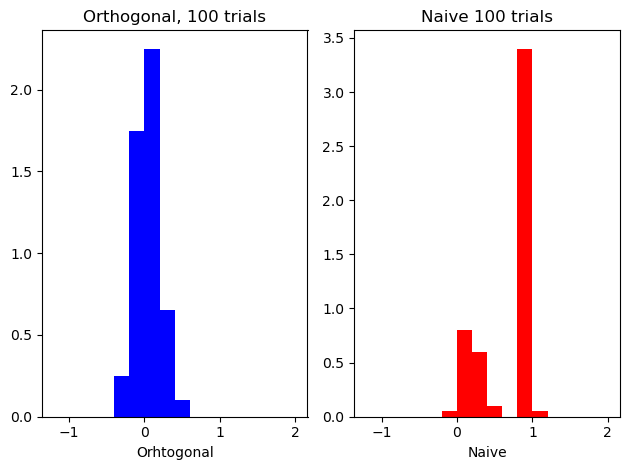

In [10]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , range = (-2, 2), density = True , bins = Orto_breaks, color ='blue')
axs[1].hist( Naive - 10, range = (-2, 2), density = True , bins = Naive_breaks, color = 'red' )

axs[0].title.set_text('Orthogonal, 100 trials')
axs[1].title.set_text('Naive 100 trials', )

axs[0].set_xlabel( 'Orhtogonal' )
axs[1].set_xlabel( 'Naive' )


# Simulation Design 2

In [11]:
# Set seed
np.random.seed(0)
B2=1000
Naive = np.zeros( B2 )
Orthogonal = np.zeros( B2 )

In [13]:
for i in range( 0, B2 ):
    n = 1000
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selectin method
    r_lasso_estimation = hdm.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True )

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()

    SX_IDs = np.where( coef_array != 0 )[0]

    if sum(SX_IDs) == 0 : 
        Naive[ 0 ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ]

    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]


    resY = hdm.rlasso( X , Y , post = True ).est[ 'residuals' ]
    resD = hdm.rlasso( X , D , post = True ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

Text(0.5, 0, 'Naive')

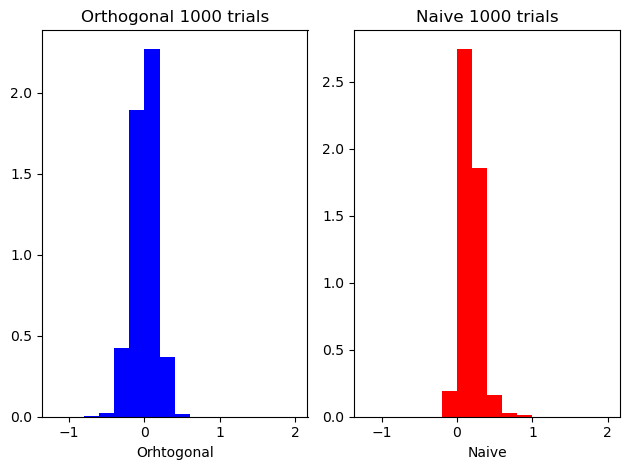

In [14]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , range = (-2, 2), density = True , bins = Orto_breaks, color ='blue')
axs[1].hist( Naive - 10, range = (-2, 2), density = True , bins = Naive_breaks,  color ='red' )

axs[0].title.set_text('Orthogonal 1000 trials')
axs[1].title.set_text('Naive 1000 trials')

axs[0].set_xlabel( 'Orhtogonal' )
axs[1].set_xlabel( 'Naive' )


# Simulation Design 3

In [16]:
# Set seed
np.random.seed(0)
B3=10000
Naive = np.zeros( B3 )
Orthogonal = np.zeros( B3 )

In [17]:
for i in range( 0, B3 ):
    n = 1000
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selectin method
    r_lasso_estimation = hdm.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True )

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()

    SX_IDs = np.where( coef_array != 0 )[0]

    if sum(SX_IDs) == 0 : 
        Naive[ 0 ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ]

    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]


    resY = hdm.rlasso( X , Y , post = True ).est[ 'residuals' ]
    resD = hdm.rlasso( X , D , post = True ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

Text(0.5, 0, 'Naive')

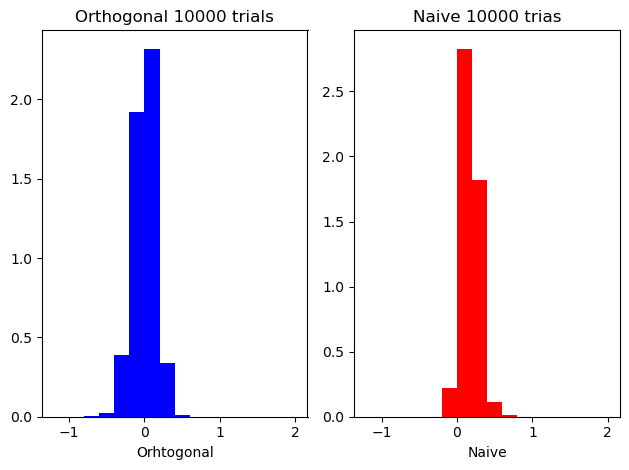

In [18]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , range = (-2, 2), density = True , bins = Orto_breaks, color ='blue' )
axs[1].hist( Naive - 10, range = (-2, 2), density = True , bins = Naive_breaks, color = 'red' )

axs[0].title.set_text('Orthogonal 10000 trials')
axs[1].title.set_text('Naive 10000 trias')

axs[0].set_xlabel( 'Orhtogonal' )
axs[1].set_xlabel( 'Naive' )


# Interpretation

The distribution of the histograms is different because they are grouped at various points. When B, what is the number of trials, is higher, the distribution is bigger. Also, the orthogonal should be centered in zero and the Naive should be centered in numbers higher than zero. The last one is biased to the right.

The econometric explanation is based on the approach to data modeling. For the orthogonal distribution, it is assumed that the features (variables) are orthogonal to each other, meaning that they are not correlated. When the errors are orthogonal to each other, it means that they are not correlated and that there is no systematic bias in the relationship between the dependent variable and the dependent variables. This is desirable because it implies that the regression model effectively captures the relationship between variables without additional bias. Zero-centering of the distribution can arise due to the way the model is specified, such as including an intercept or by standardizing variables. On the other hand, for the Naïve distribution, the bias to the right may arise from the nature of the data and the way the conditional probabilities of the variables are modeled. This could be related to the distribution of errors in a regression model. If errors have an asymmetric distribution, such as a right-weighted (positively biased) tail distribution, this can affect how relationships between variables are modeled.


# Parallel computing

Using parallel computing, the running time is lower. The multiprocessing module allows you to create multiple child processes, each of which can execute code independently. These processes can take advantage of the multiple CPU cores available on your machine, resulting in workload distribution and, in many cases, a significant reduction in execution time..
For example (B=100) 

Without using parallel computing, for the simulation design 1, the running time is 5 minutes

In [4]:
import multiprocessing
import time

In [2]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [19]:
def sleep(sleep_sec=0.5):
    print(f'Sleeping for {sleep_sec} seconds')
    time.sleep(sleep_sec)
    print('Finished sleeping')

if __name__ == "__main__":
    start_time = time.perf_counter()
    processes = []

    # Creates 100 processes then starts them
    for i in range(100):
        p = multiprocessing.Process(target=sleep, args=(1.0,))
        p.start()
        processes.append(p)

    # Joins all the processes
    for p in processes:
        p.join()

    finish_time = time.perf_counter()
    tiempo=finish_time-start_time

    print("With Parallel computing, the running time is ", tiempo, "minutes")

With Parallel computing, the running time is  4.026202299981378 minutes


# Double Lasso - Using School data

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model as lm
from statsmodels.api import OLS, add_constant
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

# Load the data
url = "https://raw.githubusercontent.com/gsbDBI/ExperimentData/97a11199ba559f01c7b3803a1493ffa08631732e/School/bruhn2016.csv"
db = pd.read_csv(url)
db = db.dropna(subset=['outcome.test.score', 'school', 'failed.at.least.one.school.year', 'is.female', 'treatment'])
db.columns = [col.replace('.', '_') for col in db.columns]
# Read the data
db.head()

,outcome_test_score,treatment,school,is_female,mother_attended_secondary_school,father_attened_secondary_school,failed_at_least_one_school_year,family_receives_cash_transfer,has_computer_with_internet_at_home,is_unemployed,has_some_form_of_income,saves_money_for_future_purchases,intention_to_save_index,makes_list_of_expenses_every_month,negotiates_prices_or_payment_methods,financial_autonomy_index
2,56.671661,1,35002914,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,48.0,0.0,1.0,56.0
3,29.079376,0,35908915,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,27.0
4,49.563534,1,33047324,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,50.0,0.0,1.0,31.0
5,43.099434,0,53012542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,93.0,0.0,1.0,77.0
6,71.329597,0,53006984,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,52.0,0.0,1.0,43.0


$y= \alphaD + \beta'W + \epsilon$
$y_hat=y-X'W$; $D_hat=D-X_{n1.1}W$
and
$\alpha=argmin_{aeR}E[y_hat-aD_hat]'= E[D_hat^2]^-1*E[D_hat_y]$
you can get the next expression (Use the Implicit Theorem Fucntion)


In [66]:
# A look at the variables
db.columns

Index(['outcome_test_score', 'treatment', 'school', 'is_female',
       'mother_attended_secondary_school', 'father_attened_secondary_school',
       'failed_at_least_one_school_year', 'family_receives_cash_transfer',
       'has_computer_with_internet_at_home', 'is_unemployed',
       'has_some_form_of_income', 'saves_money_for_future_purchases',
       'intention_to_save_index', 'makes_list_of_expenses_every_month',
       'negotiates_prices_or_payment_methods', 'financial_autonomy_index'],
      dtype='object')

In [23]:
# Define outcome variable and control variables
outcome = 'financial_proficiency_score'

## OLS

In [18]:
modelo1a = 'outcome_test_score ~ treatment'
modelo1b = 'outcome_test_score ~ treatment + school'
modelo1c = 'outcome_test_score ~ treatment + school + failed_at_least_one_school_year + is_female'


In [97]:
# Models
ols_model_1a = smf.ols(formula=modelo1a, data=db).fit()
ols_model_1b = smf.ols(formula=modelo1b, data=db).fit()
ols_model_1c = smf.ols(formula=modelo1c, data=db).fit()
table_1_pd = pd.DataFrame({
    'Coefficient': [coef],
    'Std. Error': [std_error],
    'Conf. Interval Lower': [conf_int[0]],
    'Conf. Interval Upper': [conf_int[1]]
})
table_1_pd.index = ['OLS']

In [44]:
#Summary
print(ols_model_1a.summary())
print(ols_model_1b.summary())
print(ols_model_1c.summary())


                            OLS Regression Results                            
Dep. Variable:     outcome_test_score   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     350.1
Date:                Tue, 14 May 2024   Prob (F-statistic):           2.96e-77
Time:                        16:15:02   Log-Likelihood:                -62963.
No. Observations:               15365   AIC:                         1.259e+05
Df Residuals:                   15363   BIC:                         1.259e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.4976      0.168    335.830      0.0

## Double LASSO using cross Validation 

In [45]:
# Create main variables
Y = db['outcome_test_score']
W = db[['school', 'failed_at_least_one_school_year','is_female']]
D = db['treatment']

In [78]:
#  Run the Lasso regressions of Y on W and D on W
lasso_Y_W = LassoCV(cv=10).fit(W, Y)
lasso_D_W = LassoCV(cv=10).fit(W, D)

In [104]:
# Obtain the resulting residuals
W_D_residuals = D - lasso_D_W.predict(W)
W_Y_residuals = Y - lasso_Y_W.predict(W)
W_D_residuals,W_Y_residuals

(2        0.485619
 3       -0.515259
 4        0.487513
 5       -0.531828
 6       -0.531822
            ...   
 17293   -0.514415
 17294    0.485610
 17295   -0.514384
 17296   -0.512456
 17297   -0.531823
 Name: treatment, Length: 15365, dtype: float64,
 2        -3.958683
 3       -31.554811
 4       -11.058516
 5       -17.607299
 6        10.622888
            ...    
 17293    -0.327691
 17294   -11.140557
 17295    -4.173041
 17296    -0.921294
 17297    -3.191106
 Name: outcome_test_score, Length: 15365, dtype: float64)

We run the least squares of $Y$ on $D$ to obtain the estimator $\alpha$

In [105]:
ols_model = OLS(W_Y_residuals, W_D_residuals).fit()
coef = ols_model.params['treatment']
conf_int = ols_model.conf_int().loc['treatment']
std_error = ols_model.bse['treatment']

# Create dataframe to view the results
table_2_pd = pd.DataFrame({
    'Coefficient': [coef],
    'Std. Error': [std_error],
    'Conf. Interval Lower': [conf_int[0]],
    'Conf. Interval Upper': [conf_int[1]]
})
table_2_pd.index = [ "LASSO_CV" ]
# Results
print(table_2_pd)


          Coefficient  Std. Error  Conf. Interval Lower  Conf. Interval Upper
LASSO_CV     4.470528    0.228846              4.021963              4.919093


## Double Lasso using theorical Lambda

In [102]:
from sklearn.linear_model import Lasso

# Set a theorical lambda
theorical_lambda = 0.5

# Run the Lasso regressions of Y on W and D on W, then calculate the residuals
lasso_Y_W = Lasso(alpha=theorical_lambda).fit(W, Y)
W_Y_residuals = Y - lasso_Y_W.predict(W)

lasso_D_W = Lasso(alpha=theorical_lambda).fit(W, D)
W_D_residuals = D - lasso_D_W.predict(W)

# OLS
ols_model = OLS(W_Y_residuals, W_D_residuals).fit()
print(ols_model.summary())
oef = ols_model.params['treatment']
conf_int = ols_model.conf_int().loc['treatment']
std_error = ols_model.bse['treatment']

# Create dataframe to view the results
table_3_pd = pd.DataFrame({
    'Coefficient': [coef],
    'Std. Error': [std_error],
    'Conf. Interval Lower': [conf_int[0]],
    'Conf. Interval Upper': [conf_int[1]]
})
table_3_pd.index = [ "LASSO_lambda" ]
# Results
print(table_3_pd)


                                 OLS Regression Results                                
Dep. Variable:     outcome_test_score   R-squared (uncentered):                   0.024
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              381.6
Date:                Tue, 14 May 2024   Prob (F-statistic):                    5.75e-84
Time:                        19:13:43   Log-Likelihood:                         -62544.
No. Observations:               15365   AIC:                                  1.251e+05
Df Residuals:                   15364   BIC:                                  1.251e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Double Lasso using partialling out 

In [60]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git 

fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [61]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy

In [67]:
Y = db['outcome_test_score']
W = db[['school', 'failed_at_least_one_school_year','is_female']]
D = db['treatment']

In [68]:
lasso_direct = hdmpy.rlassoEffect(x=W, y=Y, d=D, method="partialling out")  # put as argument method="partialling out"
lasso_direct

{'alpha': 4.4746885,
 'se': array([0.22785877]),
 't': array([19.63799141]),
 'pval': array([7.32381184e-86]),
 'coefficients': 4.4746885,
 'coefficient': 4.4746885,
 'coefficients_reg':                      0
 (Intercept)  59.124372
 x0            0.000000
 x1           -7.024509
 x2            2.958220,
 'selection_index': array([[False],
        [ True],
        [ True]]),
 'residuals': {'epsilon': array([[ -7.5951276 ],
         [-30.71272423],
         [-14.70325519],
         ...,
         [ -3.33478691],
         [ -0.09147789],
         [ -2.27649452]]),
  'v': array([[ 0.48812234],
         [-0.51187766],
         [ 0.48812234],
         ...,
         [-0.51187766],
         [-0.51187766],
         [-0.51187766]], dtype=float32)},
 'samplesize': 15365}

In [69]:
lasso_direct['alpha']

4.4746885

In [72]:
est_lasso_hdm = lasso_direct['alpha']
std_lasso_hdm = lasso_direct["se"]
lower_ci_lasso_hdm = est_lasso - 1.96*std_lasso
upper_ci_lasso_hdm = est_lasso + 1.96*std_lasso

In [95]:
table_4 = np.zeros( (1, 4) )

table_4[0,0] = est_lasso_hdm   
table_4[0,1] = std_lasso_hdm    
table_4[0,2] = lower_ci_lasso_hdm 
table_4[0,3] = upper_ci_lasso_hdm     


table_4_pd = pd.DataFrame( table_4, columns = [ "Coefficient","Std. Error", "Conf. Interval Lower", "Conf. Interval Upper"  ]) 
table_4_pd.index = [ "LASSO_direct" ]
table_4_pd

C:\Users\Josue\AppData\Local\Temp\ipykernel_33952\2652607470.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  table_4[0,1] = std_lasso_hdm


,Coefficient,Std. Error,Conf. Interval Lower,Conf. Interval Upper
LASSO_direct,4.474689,0.227859,4.02199,4.919066


In [106]:
#Show all the previous results
combined_pd = pd.concat([table_1_pd,table_2_pd,table_3_pd, table_4_pd])
print(combined_pd)

              Coefficient  Std. Error  Conf. Interval Lower  \
OLS              4.398477    0.235161              3.937533   
LASSO_CV         4.470528    0.228846              4.021963   
LASSO_lambda     4.398477    0.228846              4.021963   
LASSO_direct     4.474689    0.227859              4.021990   

              Conf. Interval Upper  
OLS                       4.859421  
LASSO_CV                  4.919093  
LASSO_lambda              4.919093  
LASSO_direct              4.919066  


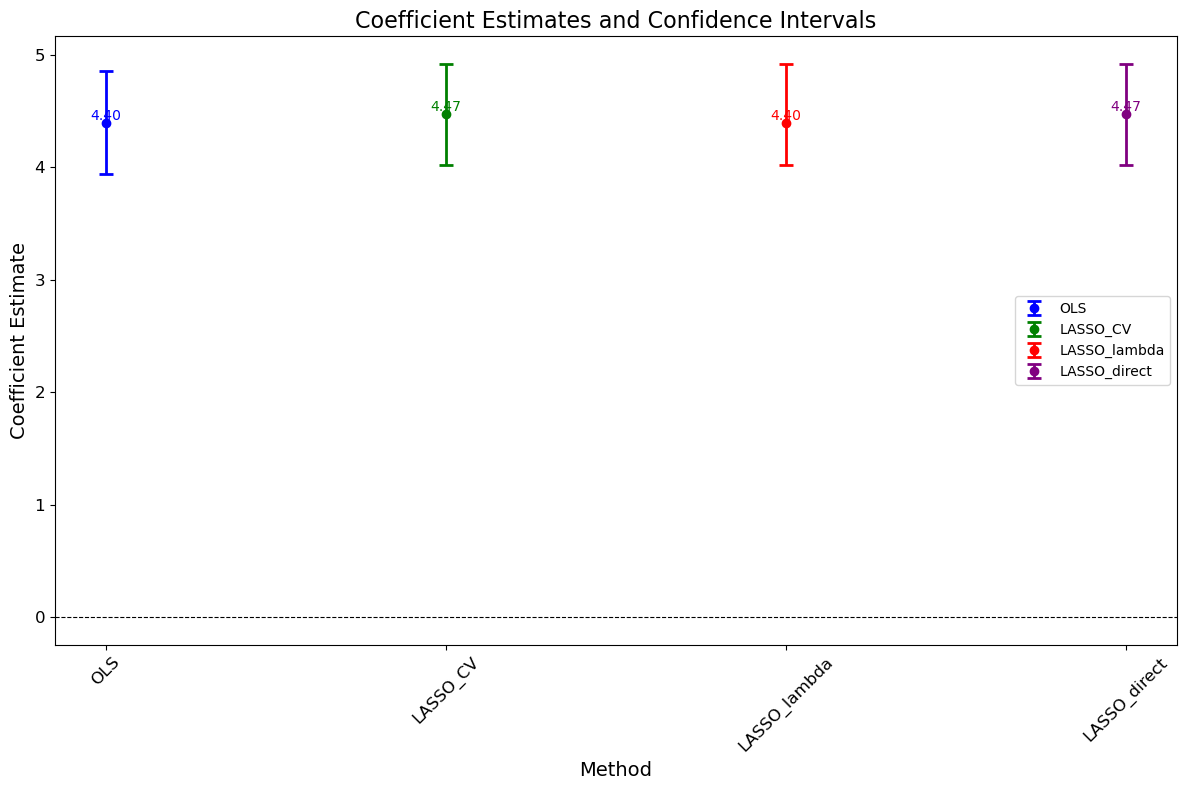

In [110]:
fig, ax = plt.subplots(figsize=(12, 8))

#Define the colors
colors = ['blue', 'green', 'red', 'purple']

# Plot coefficients and intervals
for i, method in enumerate(combined_pd.index):
    ax.errorbar(
        method, 
        combined_pd.loc[method, 'Coefficient'], 
        yerr=[[combined_pd.loc[method, 'Coefficient'] - combined_pd.loc[method, 'Conf. Interval Lower']], 
              [combined_pd.loc[method, 'Conf. Interval Upper'] - combined_pd.loc[method, 'Coefficient']]], 
        fmt='o', 
        color=colors[i], 
        capsize=5, 
        capthick=2, 
        elinewidth=2,
        label=method
    )
    ax.text(method, combined_pd.loc[method, 'Coefficient'], 
            f'{combined_pd.loc[method, "Coefficient"]:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color=colors[i])

# Add labels
ax.set_xlabel('Method', fontsize=14)
ax.set_ylabel('Coefficient Estimate', fontsize=14)
ax.set_title('Coefficient Estimates and Confidence Intervals', fontsize=16)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Show the plot
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()